In [ ]:
# To Do
# 

In [1]:
Author = 'Conrad'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import time
import pytz
local_timezone = 'America/Los_Angeles'
from time import gmtime, strftime

from scipy import stats
import numpy as np
import pandas as pd
#from pandas.plotting import scatter_matrix
import xarray as xr
from pandas import Series
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)

import yfinance as yf

from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import maxabs_scale
from sklearn.preprocessing import Binarizer as binarizer

from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression
from sklearn import cluster
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import mixture
                                  
from sklearn.metrics import mean_squared_error as rmse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r_squared
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


#kbest = SelectKBest(chi2, k=20)

                                  
        

In [2]:
# SET KEYLINE TIME RELATED PARAMETERS
IS = slice("2011-08-26", "2016-08-05")
OOS = slice("2016-08-06", "2023-11-30")
ALL = slice("2011-08-26","2023-11-30")
cal = {}
cal['z_score_window'] = 252
cal['regression_est_window'] = 400
cal['sim_time'] = time.strftime('%x %X')
cal['OOS'] = slice("2016-08-06", "2023-11-30")
cal['IS'] = slice("2000-08-06", "2016-08-05")
cal['ALL'] = slice("2000-08-06", "2016-08-05")

print(cal['sim_time'])
print('In-Sample',IS)
print('Out-of-Sample',OOS)
print('All-Dates',ALL)


12/04/23 08:50:53
In-Sample slice('2011-08-26', '2016-08-05', None)
Out-of-Sample slice('2016-08-06', '2023-11-30', None)
All-Dates slice('2011-08-26', '2023-11-30', None)


In [3]:
# FUNCTION FOR TIME-SAFE Z-SCORES
def z_score(df,window = cal['z_score_window']):
    window = cal['z_score_window']
    rstd = df.rolling(window=window,min_periods=window).std()
    #print('std',rstd)
    rmean = df.rolling(window=window,min_periods=window).mean()
    #print('mean',rmean)
    z = (df - rmean) / rstd
    #print('z',z)
    z = z.dropna()
    #print('zdropna',z)
    return z

In [4]:
# FUNCTIONS FOR Re-Basing Returns & computing log returns from a price levels

def rebase_rets(input):
    output = pd.DataFrame(input).set_index(pd.DatetimeIndex(input.index))
    output = output.dropna()
    output = 1+output.cumsum()
    return output

def log_returns(df):
    df = np.log(df)
    df = df - df.shift(1)
    #df.index.name = None
    return df

def pct_returns(df):
    df = df.pct_change()
    return df

def generate_train_predict_calender(df, window_size):
    date_ranges = []
    index = df.index
    num_days = len(index)

    for i in range(0, num_days - window_size):
        #if i + window_size <= len(index):
        train_start_date = index[i]
        train_end_date = index[i + window_size - 1]
        prediction_date = index[i + window_size]
        date_ranges.append([train_start_date, train_end_date, prediction_date])

    return date_ranges


def apply_ewm(X, halflife):
    return X.ewm(halflife=halflife).mean()

In [6]:
#  Load and preprocess the data

y_level = yf.download(['SPY'])['Adj Close'].dropna()
#y_level = y_level.to_frame(name='SPY')
y = log_returns(y_level)  # process as log returns

X_level = pd.read_pickle('Hull_X_levels.pkl')
X_level = X_level.drop(['US3M','PCUSEQTR','SPXDIV'],axis=1)

X_log_returns = log_returns(X_level).shift(1)  # Lagging all features 1 day 
X = z_score(X_log_returns,252) # preprocess as z-scores

# Sync the indexes
y = y.reindex(X.index)
#y = pd.DataFrame(y,columns=['SPY'])
y

[*********************100%%**********************]  1 of 1 completed


Date
2012-08-28   -0.000990
2012-08-29    0.000778
2012-08-30   -0.007234
2012-08-31    0.004757
2012-09-04   -0.000921
                ...   
2022-11-15    0.008493
2022-11-16   -0.007658
2022-11-17   -0.003065
2022-11-18    0.004530
2022-11-21   -0.003643
Name: Adj Close, Length: 2576, dtype: float64

In [ ]:
# for col in X_level.columns:
#     if X_level[col].le(0).any():
#         print(col)

# for col in X_level.columns:
#     if np.log(X_level[col]).isna().any():
#        print(X_level[col])

In [7]:
def t_func_1(df,pred_col='predicted', actual_col='actual',new_col='perf'):
    t_conditions = [ df[pred_col] >= 0, df[pred_col] < 0 ]
    t_positions =  [ df[actual_col]*1,  df[actual_col]*-1 ]
    return np.select(t_conditions,t_positions, default=np.nan) # Apply trading logic here


def t_func_2(df,pred_col='predicted', actual_col='actual',new_col='perf'):
    t_conditions = [ df[pred_col] >= 0, df[pred_col] < 0 ]
    t_positions =  [ df[actual_col]*1.8,  df[actual_col]*0 ]
    return np.select(t_conditions,t_positions, default=np.nan) # Apply trading logic here

In [8]:
all_data = slice(y.index.min(),y.index.max())

In [9]:
def sim_stats(regout_list,sweep_tags,author='CG',trange = all_data):
    df = pd.DataFrame()
    for n, testlabel in enumerate(sweep_tags):
        reg_out = regout_list[n].loc[trange,:]
        df.loc['mean',testlabel] = mean = 252*reg_out.perf_ret.mean()
        df.loc['stdev',testlabel] = std = (np.sqrt(252))*reg_out.perf_ret.std()
        df.loc['sharpe',testlabel] = mean / std
        df.loc['pos_bet_ratio',testlabel] = np.sum(np.isfinite(reg_out['predicted']) & (reg_out['predicted'] > 0)) / np.sum(np.isfinite(reg_out['predicted']))

        df.loc['rmse',testlabel] = np.sqrt(rmse(reg_out.predicted,reg_out.actual))
        df.loc['mae',testlabel] = mae(reg_out.predicted,reg_out.actual)
        df.loc['evs',testlabel] = evs(reg_out.predicted,reg_out.actual)
        df.loc['r2',testlabel] = r_squared(reg_out.predicted,reg_out.actual)
        df.loc['benchmark return',testlabel] = bench_ret = 252*reg_out.actual.mean()
        df.loc['benchmark std',testlabel] = bench_std = (np.sqrt(252))*reg_out.actual.std()
        df.loc['benchmark sharpe',testlabel] = bench_ret / bench_std
        df.loc['beg_pred',testlabel] = min(reg_out.predicted.index).date()
        df.loc['end_pred',testlabel] = max(reg_out.predicted.index).date()
        df.loc['train window',testlabel] = window=cal['regression_est_window'] 
        df.loc['z_score_window',testlabel] = cal['z_score_window']
        df.loc['sim_time',testlabel] =  datetime.now(pytz.timezone(local_timezone)).strftime("%x %-I:%-m%p") 
        df.loc['author',testlabel] = author
    return df

In [19]:
# ROLL FORWARD SIMULATOR - 1) TRAIN UP TO T-1, 2) PREDICT AT T, 3) TRADE

def Simulate(X,y,window=cal['regression_est_window'],pipe_steps={},dims_dict={}):    
    regout = pd.DataFrame(index=y.index)
    
    date_ranges = generate_train_predict_calender(X, window)
    
    pipe = Pipeline(steps=pipe_steps)
    pipe.set_params(**dims_dict)

    for n,dates in enumerate(date_ranges):

        start_training, end_training, prediction_date = dates[0], dates[1],dates[2]

        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]

        if n%60 == 0:
            #print('estimating at', end_training)
            pipe.fit(fit_X,fit_y)
        #print('pred_date',prediction_date,'features = ',pipe.named_steps['eln'].n_features_in_)
        #regout.loc[prediction_date,'expl_var'] = pipe.named_steps['pca'].explained_variance_ratio_[2]
        #regout.loc[prediction_date,'coeff_1st_dim'] = pipe.named_steps['reg'].coef_[0]
                
        regout.loc[prediction_date,'predicted'] = pipe.predict(pred_X)
    
    return regout.dropna()

In [16]:
# Simulate Dim Reduction -> Linreg
last_printed_time = datetime.now()
regout_list = []
Results_xr = xr.Dataset()
Results_df = pd.DataFrame()

## Dim Reduction
pca = PCA()
clust = cluster.FeatureAgglomeration(n_clusters=4)
kbest = SelectKBest(chi2, k=20)

## Estimators
ols = LinearRegression()
eln = ElasticNet()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=.5)

In [17]:
y

Date
2012-08-28   -0.000990
2012-08-29    0.000778
2012-08-30   -0.007234
2012-08-31    0.004757
2012-09-04   -0.000921
                ...   
2022-11-15    0.008493
2022-11-16   -0.007658
2022-11-17   -0.003065
2022-11-18    0.004530
2022-11-21   -0.003643
Name: Adj Close, Length: 2576, dtype: float64

In [18]:
#pipe = Pipeline([('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': halflife}))])
regout_list = []
Results_xr = xr.Dataset()
Results_df = pd.DataFrame()
max_sweep_n = 5
sweep_n = [n for n in range(5,20)]
last_printed_time = datetime.now()

kbest_tags = sweep_tags = ['kbest_'+str(n)+'_reg' for n in sweep_n]

for n, test_param in enumerate(sweep_n):
    print('test',n)
    
    # pipe_steps=[('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': test_param})), 
    #             ('pca', PCA(n_components=2)),
    #             ('ols', LinearRegression(fit_intercept=True))]

    pipe_steps=[('kbest',  SelectKBest(mutual_info_regression, k=test_param)), 
                ('ols', LinearRegression(fit_intercept=True))]


    dims_dict = {} 
    
    regout_df = Simulate(X,y,window=cal['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    regout_df['actual'] = y[regout_df.predicted.index].dropna()
    regout_df['perf_ret'] = t_func_2(regout_df,pred_col='predicted', actual_col='actual',new_col = 'perf') # Enter Trading Func
    regout_df['perf_mtm'] = regout_df['perf_ret'].cumsum()
    regout_df['es_mtm'] = regout_df['actual'].cumsum()
    regout_list.append(regout_df)
    
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])

    

    current_time = datetime.now()
    time_elapsed = current_time - last_printed_time
    last_printed_time = current_time
    print(sweep_tags[n],'sim time = ',time_elapsed)

Results_df = sim_stats(regout_list,sweep_tags,author='CG')
   

test 0
estimating at 2014-04-02 00:00:00
estimating at 2014-06-27 00:00:00
estimating at 2014-09-23 00:00:00
estimating at 2014-12-17 00:00:00
estimating at 2015-03-17 00:00:00
estimating at 2015-06-11 00:00:00
estimating at 2015-09-04 00:00:00
estimating at 2015-12-01 00:00:00
estimating at 2016-02-29 00:00:00
estimating at 2016-05-24 00:00:00
estimating at 2016-08-18 00:00:00
estimating at 2016-11-11 00:00:00
estimating at 2017-02-09 00:00:00
estimating at 2017-05-08 00:00:00
estimating at 2017-08-02 00:00:00
estimating at 2017-10-26 00:00:00
estimating at 2018-01-24 00:00:00
estimating at 2018-04-20 00:00:00
estimating at 2018-07-17 00:00:00
estimating at 2018-10-10 00:00:00
estimating at 2019-01-08 00:00:00
estimating at 2019-04-04 00:00:00
estimating at 2019-07-01 00:00:00
estimating at 2019-09-25 00:00:00
estimating at 2019-12-19 00:00:00
estimating at 2020-03-18 00:00:00
estimating at 2020-06-12 00:00:00
estimating at 2020-09-08 00:00:00
estimating at 2020-12-02 00:00:00
estimat

In [20]:
X_new.shape

NameError: name 'X_new' is not defined

In [ ]:
kb = SelectKBest(mutual_info_regression, k=20).fit(X, y)
kb.set_output(transform="pandas")
newf = kb.transform(X)
newf.T
#k#b.feature_names_in_
#k#b.get_feature_names_out

In [ ]:

Results_df = pd.concat([sim_stats(regout_list,sweep_tags,author='CG',trange=cal['IS']),sim_stats(regout_list,sweep_tags,author='CG',trange=cal['OOS'])],axis=1)
Results_df

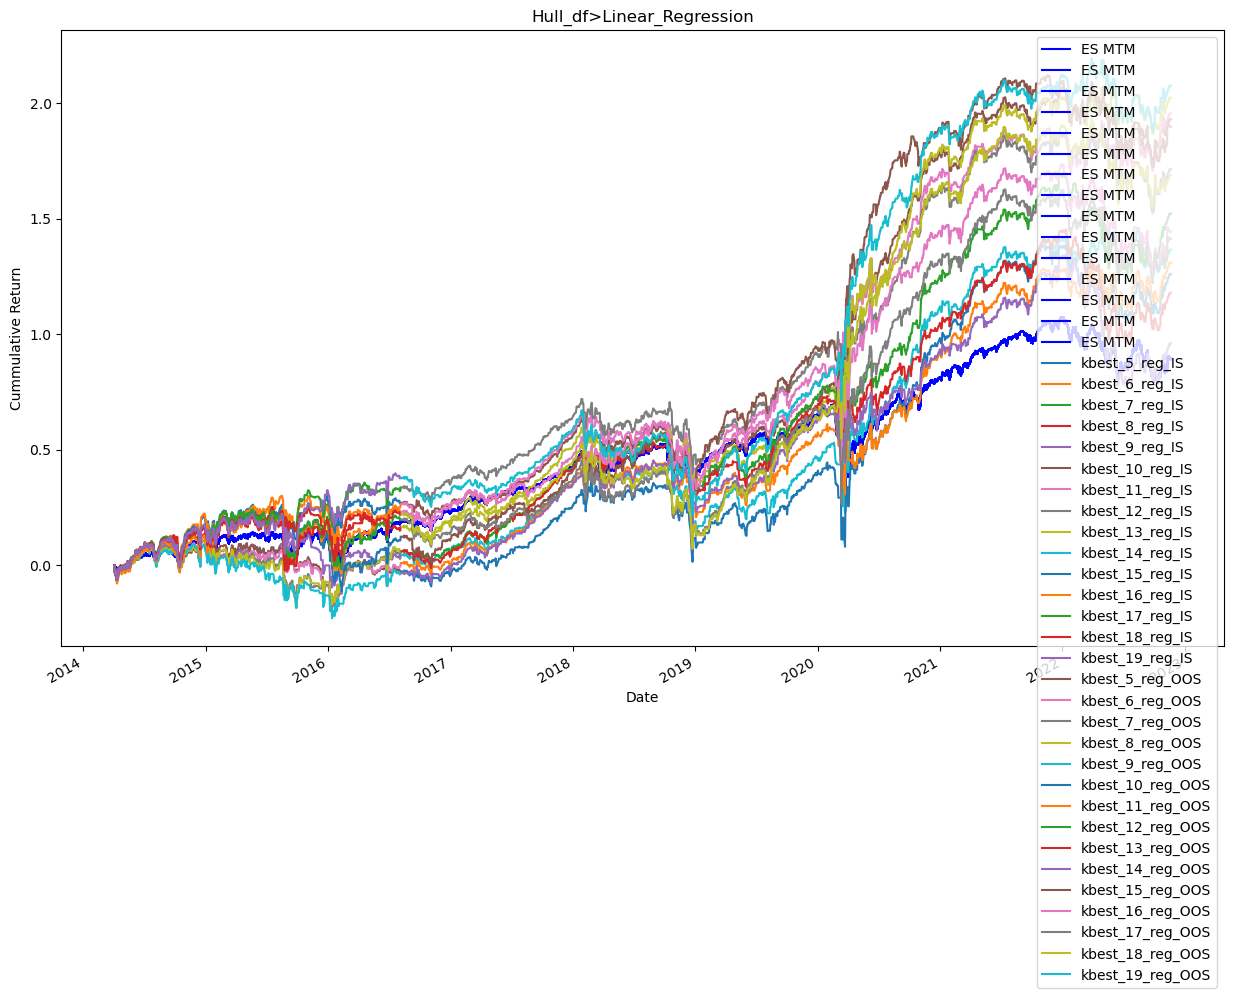

In [21]:
#IS_lab = [x+'_IS' for x in sweep_tags]
#OOS_lab = [x+'_OOS' for x in sweep_tags]

Results_xr['es_mtm'].plot.line(x='Date', label='ES MTM', color='blue')
Results_xr['perf_mtm'].sel(Date=cal['IS']).plot.line(x='Date', label=[x+'_IS' for x in sweep_tags])
Results_xr['perf_mtm'].sel(Date=cal['OOS']).plot.line(x='Date', label=[x+'_OOS' for x in sweep_tags])

plt.title('Hull_df>Linear_Regression')
plt.ylabel('Cummulative Return')
plt.legend()  # Ensure this line is present to display the legend
plt.show()

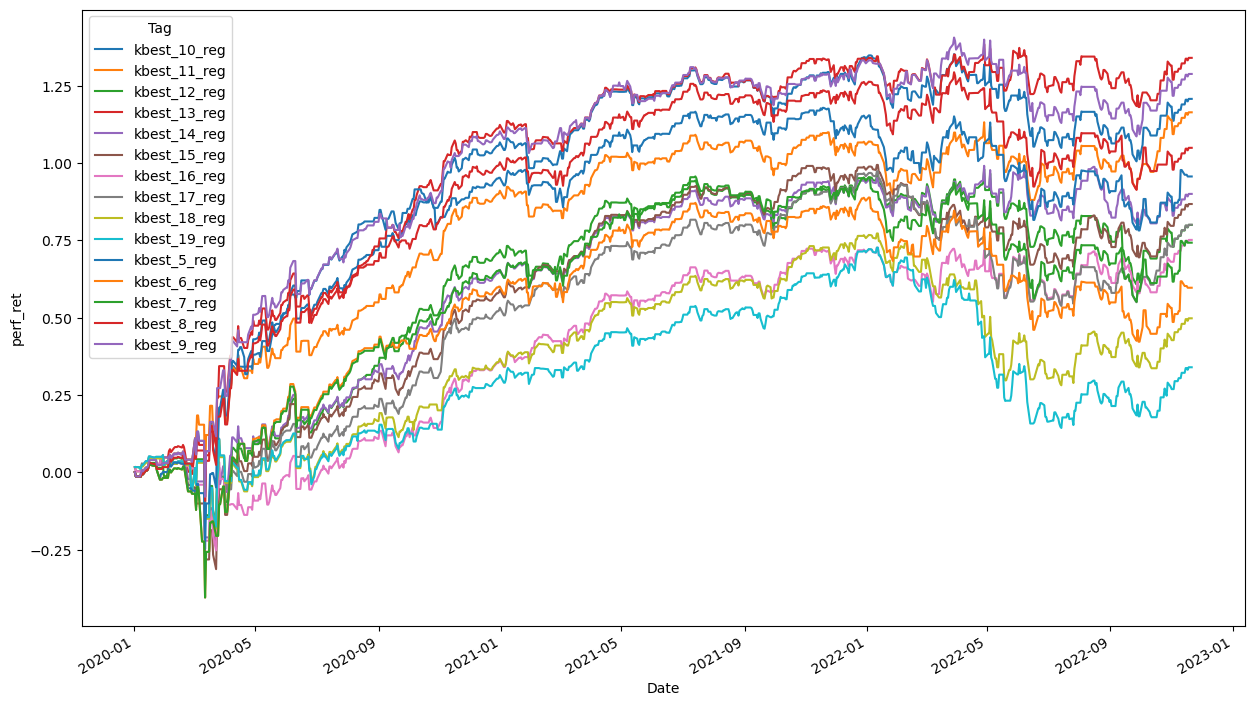

In [22]:
#Results_xr['predicted'].sel(Date=cal['OOS']).cumsum().plot.line(x='Date', label=[x+'_IS' for x in sweep_tags])
Results_xr['perf_ret'].sel(Date=slice("2020","2022")).cumsum(dim='Date').plot.line(x='Date', label=sweep_tags)

In [ ]:
# estimators = [
#     ("OLS", LinearRegression()),
#     ("Theil-Sen", TheilSenRegressor(random_state=42)),
#     ("RANSAC", RANSACRegressor(random_state=42)),
# ]

# ols =  LinearRegression(fit_intercept=True)
# ridge = Ridge(alpha=.9,fit_intercept=True)
# eln = ElasticNet(random_state=0,alpha=.5,l1_ratio=.5,fit_intercept=True,selection='random')

# learners = [ols, ridge, eln]
# learner_tags = sweep_tags = [str(x) for x in learners]


# for n, learner_tested in enumerate(learners):
#     pipe_steps=[('pca', PCA(n_components=2)), (learner_tags[n], learners[n])]
#     dims_dict = {}

#     regout_df = Simulate(X,y,window=cal['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
#     Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
#     sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
#     Results_xr = xr.merge([Results_xr,sim_xr])





In [ ]:
df = pd.concat([X,y],axis=1)

correlations = df.corr()["SPY"].iloc[:-1]  # Exclude the target column from the result

# Create a DataFrame to report the correlations
correlation_report = pd.DataFrame({"Feature": correlations.index, "Pearson Correlation": correlations.values})
report = correlation_report.sort_values(by=['Pearson Correlation'])
for row in range(len(report.index)):
    print(row,report.loc[row,'Feature'],report.loc[row,'Pearson Correlation'])



In [ ]:

y_pred = Results_xr['predicted'].sel(Tag='ewm_3_reg_oos').to_dataframe().drop('Tag',axis=1)
y_test = Results_xr['actual'].sel(Tag='ewm_3_reg_oos').to_dataframe().drop('Tag',axis=1)
df = pd.concat([y_pred,y_test],axis=1)
df['pos_bets'] = df['actual'].loc[df['predicted'] > 0]
#df.loc[(df['predicted'] > 0).index,df['actual']]
df['neg_bets'] = df['actual'].loc[df['predicted'] < 0]
df.describe()

In [ ]:
report.sort_values(by=['Pearson Correlation'])

In [ ]:
df